In [1]:
%matplotlib inline
import sys
import json
sys.path.append('../src')

import requests

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

# Match PUMAs to commuter zones (file from Dorn)
cz_match = pd.read_stata(acs_dir / 'data/cw_puma2010_czone.dta')
cz_dict = {cz: [(puma, afactor) 
                for puma, z, afactor 
                in cz_match[cz_match['czone'] == cz].values] 
           for cz in cz_match['czone'].unique()}

In [2]:
#variables = {'DP05_0024E': 'Age 65+',
#             'DP05_0019E': 'Age 0-17',
#             'DP05_0001E': 'Total'}
#srs = ','.join(variables.keys())
#area = 'for=public%20use%20microdata%20area:*'
#base = 'https://api.census.gov/data/2018/acs/acs1/profile'
#url = f'{base}?get={srs}&{area}&key={census_key}'
#r = requests.get(url)

#df = pd.DataFrame(r.json()[1:])
#df.columns = r.json()[0]
#df['PUMA'] = [float(f"{i[-2]}{i[-1]}") for i in r.json()[1:]]
#df = df.set_index('PUMA')[variables.keys()]

#df.to_csv(acs_dir / 'census_acs_age.csv')#

In [3]:
df = pd.read_csv(acs_dir / 'census_acs_age.csv', index_col='PUMA')

d = {}
for cz, puma_list in cz_dict.items(): 
    pop = 0
    u18 = 0
    o64 = 0
    for puma, afactor in puma_list:
        data = dict(df.loc[puma].astype(int) * afactor)
        pop += data['DP05_0001E']
        u18 += data['DP05_0019E']
        o64 += data['DP05_0024E']
    
    u18sh = u18 / pop
    o64sh = o64 / pop
    results = {'Total': pop, 'Age 0-17': u18sh, 'Age 65+': o64sh}
    d[cz] = results
    
result = pd.DataFrame(d).T

result.to_csv(data_dir / 'acs_cz_age.csv', index_label='CZ90')

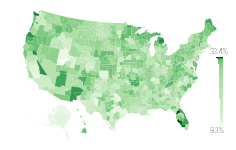

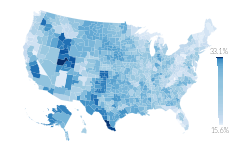

In [4]:
grps = [('Age 65+', 'over64pop.pgf', plt.cm.Greens), 
        ('Age 0-17', 'under18pop.pgf', plt.cm.Blues)]


for grp, filename, cmap in grps:
    maxval = result[grp].max()
    minval = result[grp].min()
    max_val = f'{maxval * 100:.1f}%'
    min_val = f'{minval * 100:.1f}%'

    norm = Normalize(vmin=minval, vmax=maxval)

    hi_cz = [35600, 34701, 34703, 34702, 34703]
    ak_cz = [34101, 34114, 34102, 34112, 34104, 34107, 34115, 
             34109, 34109, 34102, 34111, 34108, 34107, 34102, 
             34106, 34113, 34105, 34111, 34110, 34109, 34115, 
             34103, 34112, 34110, 34115]

    pts = np.arange(1, 101, 1)
    pct = (np.percentile(np.repeat(result[grp].values, 
                  result.Total.div(1000).astype(int).values), pts))

    # Map and legend settings
    m = Basemap(llcrnrlon=-121, llcrnrlat=20, urcrnrlon=-64, urcrnrlat=49,
                projection='lcc', lat_1=33, lat_2=45, lon_0=-95)

    fig = plt.figure(figsize=(5.0,2.5))

    m.drawmapboundary(color='white')
    m.readshapefile('/home/brian/Documents/ACS/shapefiles/cz1990', 'cz', drawbounds=False)

    ax = plt.gca()

    for info, shape in zip(m.cz_info, m.cz):
        fc = cmap(norm(d[info['cz']][grp]))
        if info['cz'] in hi_cz:
            shape = [[x + 5200000, y - 1400000] for x, y in shape]
        elif info['cz'] in ak_cz:
            shape = [(x * 0.34 + 1280000, 
                      y * 0.34 - 1300000) for x, y in shape]
        ax.add_patch(Polygon(shape, fc=fc))

    m.readshapefile('shapefiles/states', 'states', drawbounds=True, 
                    color='white', linewidth=0.05);
    ax.axis('off')    

    ax_inset = inset_axes(ax, width='-10%', height='50%', loc=4, borderpad=1.8) 
    for i, pt in enumerate(pct):
        rect = Rectangle(xy=(pt, i / 100), width=-pt, height=0.1, 
                         fc=cmap(norm(pt)), ec=None)
        ax_inset.add_patch(rect)    

    ax_inset.text(0.6, 1.05, max_val, fontsize=7)
    ax_inset.text(0.6, -0.12, min_val, fontsize=7)
    ax_inset.axis('off')
    plt.savefig(data_dir / filename, bbox_inches='tight')
    plt.show()

In [5]:
cz_names = (pd.read_excel(acs_dir / 'czlma903.xls', sheet_name='CZLMA903')
              .set_index('CZ90')
              .iloc[:, -1]
              .str.replace(' city', '')
              .str.replace(' town', '')
              .str.replace(' CDP', '')
              .str.replace(' \(remaind', '')
              .str.replace(' \(remain', '')
              .str.replace(' borough', '')
              .str.replace('Arlington, VA', 'Washington, DC')
              .to_dict())

size_cutoff = 100000

u18 = result.loc[result['Total'] > size_cutoff, 'Age 0-17'].sort_values()
o64 = result.loc[result['Total'] > size_cutoff, 'Age 65+'].sort_values()

u18.index = u18.index.map(cz_names)
o64.index = o64.index.map(cz_names)

In [6]:
v = {}
n = {}
for i in [-1, -2, -3, 0, 1, 2]:
    v[i] = f'{u18[i]*100:.1f}'
    n[i] = u18.index[i]

text = ('In 2018, among commuter zones with a population of at least 100,000, '+
        'the commuter zone (listed by largest city) with the highest share of '+
        f'its population under 18 is {n[-1]} ({v[-1]} percent), followed by {n[-2]} '+
        f'({v[-2]} percent), and {n[-3]} ({v[-3]} percent). The commuter zones with '+
        f'lowest share of the local population under 18 were {n[0]} '+
        f'({v[0]} percent), {n[1]} ({v[1]} percent), and {n[2]} '+
        f'({v[2]} percent).')

v = {}
n = {}
for i in [-1, -2, -3, 0, 1, 2]:
    v[i] = f'{o64[i]*100:.1f}'
    n[i] = o64.index[i]

text2 = ('The age 65 or older population is disproportionately concentrated in Florida. '+
         'The commuter zone with the highest share of its population over 64 is '+
         f'{n[-1]} ({v[-1]} percent), followed by {n[-2]} ({v[-2]} percent), '+
         f'and {n[-3]} ({v[-3]} percent). The commuter zones with lowest local over-'+
         f'64 population share were {n[0]} ({v[0]} percent), {n[1]} ({v[1]} percent), '+
         f'and {n[2]} ({v[2]} percent). ')


write_txt(text_dir / 'cps_u18.txt', text)
write_txt(text_dir / 'cps_o64.txt', text2)

### Age bar chart and text

In [2]:
write_txt(text_dir / 'cps_age_dt.txt', dtxt(cps_date())['mon2'])

dates = [('Latest', cps_date()), 
         ('Prev', cps_date() - pd.DateOffset(years=1)), 
         ('1989', pd.to_datetime('1989-12-01'))]

d = {y: {} for y, d in dates}
t = {y: {} for y, d in dates}

for name, date in dates:
    if date.year > 1993:
        wgt = 'PWSSWGT'
    else: 
        wgt = 'BASICWGT'
    cols = ['AGE', wgt]
    df = cps_12mo(cps_dir, date, cols)

    data = df.groupby('AGE')[wgt].sum()
    tot = data.sum()
    t[name]['tot'] = tot / 12
    d[name]['0--17'] = data.loc[:'17'].sum() / tot
    d[name]['18--29'] = data.loc['18':'29'].sum() / tot
    d[name]['30--44'] = data.loc['30':'44'].sum() / tot
    d[name]['45--64'] = data.loc['45':'64'].sum() / tot
    d[name]['64+'] = data.loc['65':].sum() / tot
    
result = pd.DataFrame(d) * 100
result[['1989', 'Latest']].to_csv(data_dir / 'cps_age.csv', index_label='name')

pop = f'{t["Latest"]["tot"] / 1_000_000:.0f}'
popp = f'{t["1989"]["tot"] / 1_000_000:.0f}'
ldate = dtxt(cps_date())['mon1']
popgr = f'{((t["Latest"]["tot"] / t["Prev"]["tot"]) - 1) * 100:.1f}'

u18 = d['Latest']['0--17'] * 100
prer = d['Latest']['45--64'] * 100
o64 = d['Latest']['64+'] * 100
u18p = d['1989']['0--17'] * 100
prerp = d['1989']['45--64'] * 100
o64p = d['1989']['64+'] * 100

if float(popgr) == 0.6:
    qual = '; '
else:
    qual = ', though'


text = (f'The CPS civilian non-institutionalized population is {pop} '+
        f'million in the year ending {ldate}, with '+
        f'growth of {popgr} percent over the past year{qual} other Census '+
        f'population growth estimates are around 0.6 percent. By age, {u18:.1f} '+
        f'percent are under the age of 18 and {o64:.1f} percent are age '+
        f'65 or older. In 1989, the US population was {popp} million, '+
        f'with {u18p:.1f} percent under 18 and {o64p:.1f} percent 65 or older. The '+
        'pre-retirement age (45--64) share of the population has increased '+
        f'to {prer:.1f} percent in the year ending {ldate} from {prerp:.1f} '+
        'percent in 1989. ')

write_txt(text_dir / 'cps_age.txt', text)    
text

'The CPS civilian non-institutionalized population is 324 million in the year ending May 2020, with growth of 0.3 percent over the past year, though other Census population growth estimates are around 0.6 percent. By age, 22.6 percent are under the age of 18 and 16.5 percent are age 65 or older. In 1989, the US population was 244 million, with 26.3 percent under 18 and 12.0 percent 65 or older. The pre-retirement age (45--64) share of the population has increased to 25.4 percent in the year ending May 2020 from 18.9 percent in 1989. '